In [1]:
## IMPORT THE NECESSARY PYTHON LIBRARIES

# Exploratory Data Analysis
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

# Catboost Training
# from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostClassifier

In [2]:
# 데이터 읽어오기
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [ ]:
# 헤드 확인
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 데이터의 컬럼 수 확인
print(df_train.shape, df_test.shape)

(891, 12) (418, 11)


In [ ]:
# 컬럼별 타입과 Null값 확인
print(df_train.info())
print()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pc

## Exploratory Data Analysis 📊🤔

In [4]:
def eda_bar_plots(feature: str, target: str = 'Survived') -> None:
    """
    The given 'feature' is expected to be a categorical feature.
    Avoid calling this function with 'feature' == 'Age' or 'Fare'
    
    This function crates 3 bar plots to perform a visual
    Data Exploration analysis of the given 'feature'.
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    
    # (1) the distribution of 'feature' in the Training data
    df1 = df_train[feature].value_counts(normalize=True) 
    df1 = df1.sort_index().reset_index()
    # Now df1 has the columns: feature and 'proportion'
    sns.barplot(data=df1, x=feature, y='proportion', ax=ax1)
    # Set the title, the xlabel, and the ylabel.
    ax1.set(
        xlabel=feature, 
        ylabel='% of each category', 
        title=feature + ': % value counts [Training Data]'
    )
    # Plot a horizontal line at the proportion of a balanced
    # distribution of the categories in 'feature'
    ax1.axhline(
        y=1/len(df1), color='green', alpha=0.4, linestyle='--'
    )
    
    # (2) the distribution of 'feature' in the Test data
    df2 = df_test[feature].value_counts(normalize=True) 
    df2 = df2.sort_index().reset_index()
    # Now df2 has the columns: feature and 'proportion'
    sns.barplot(data=df2, x=feature, y='proportion', ax=ax2)
    # Set the title, the xlabel, and the ylabel.
    ax2.set(
        xlabel=feature, 
        ylabel='% of each category', 
        title=feature + ': % value counts [Test Data]'
    )
    # Plot a horizontal line at the proportion of a balanced
    # distribution of the categories in 'feature'
    ax2.axhline(
        y=1/len(df2), color='green', alpha=0.4, linestyle='--'
    )
    
    # (3) the relationship between the 'target' and the 
    # categories of 'feature' in the training data
    df3 = df_train.groupby(feature, as_index=False).agg(
        {target: 'mean'}
    ).sort_values(by=feature)
    sns.barplot(x=feature, y=target, data=df3, ax=ax3)
    ax3.set(
        xlabel=feature,
        ylabel=f'% {target}', 
        title=f"{feature}: prob of '{target}'"
    )
    # Plot a horizontal line at the baseline prediction
    # probability: two classes -> prob=0.5
    ax3.axhline(
        y=0.5, color='green', alpha=0.4, linestyle='--'
    )

# Data Preprocessing ⚙️🧹

In [ ]:
# 'PassengerId' 컬럼 드랍 (상관관계 X)
# 제출할 때는 컬럼 다시 추가해줘야 합니다.
df_train = df_train.drop(columns=['PassengerId'])

In [ ]:
# 'Name' 컬럼에서 'honorific_title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
# '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
honorific_title_train = df_train['Name'].map(
    lambda n: n.split('.')[0].split(', ')[-1]
)
honorific_title_test = df_test['Name'].map(
    lambda n: n.split('.')[0].split(', ')[-1]
)

In [ ]:
# 새 피쳐로 사용할 컬럼 'honorific_title' 생성
top4_titles = ('Mr', 'Mrs', 'Miss', 'Master')

df_train['honorific_title'] = honorific_title_train.map(
    lambda h: h if h in top4_titles else np.nan
)
df_test['honorific_title'] = honorific_title_test.map(
    lambda h: h if h in top4_titles else np.nan
)

In [ ]:
# 'Name' 컬럼에서 'honorific_title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 'honorific_title' 생성하는 함수
def get_honorific_title(name):
    top4_titles = ('Mr', 'Mrs', 'Miss', 'Master')

    # top4 호칭으로 바꿔줄 소수 여성 호칭
    female_titles_to_Mrs = ('Mme', 'the Countess', 'Dona', 'Lady')
    female_titles_to_Miss = ('Mlle', 'Ms')

    # top4 호칭으로 바꿔줄 소수 남성 호칭
    male_titles_to_Mr = ('Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev')

    # 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
    # '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
    honorific_title = name.split('.')[0].split(', ')[-1]

    # 호칭에 따라 변환해서 리턴
    if honorific_title in top4_titles:
        return honorific_title
    elif honorific_title in female_titles_to_Mrs:
        return 'Mrs'
    elif honorific_title in female_titles_to_Miss:
        return 'Miss'
    elif honorific_title in male_titles_to_Mr:
        return 'Mr'
    else:
        return np.nan

In [ ]:
# 새 피쳐로 사용할 컬럼 'honorific_title' 생성
df_train['honorific_title'] = df_train['Name'].map(get_honorific_title)
df_test['honorific_title'] = df_test['Name'].map(get_honorific_title)

In [ ]:
# 원래 컬럼 'Name'를 드랍
df_train = df_train.drop(columns=['Name'])
df_test = df_test.drop(columns=['Name'])

In [ ]:
# 'SibSp' 카테고리화
df_train['SibSp'] = df_train['SibSp'].map(
    lambda s: str(s) if s < 2 else '>=2'
)
df_test['SibSp'] = df_test['SibSp'].map(
    lambda s: str(s) if s < 2 else '>=2'
)

In [ ]:
# 'Parch' 카테고리화 처리
df_train['Parch'] = df_train['Parch'].map(
    lambda p: '0' if p == 0 else '>0'
)
df_test['Parch'] = df_test['Parch'].map(
    lambda p: '0' if p == 0 else '>0'
)

In [7]:
# 새로운 컬럼 'Family' 생성
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1

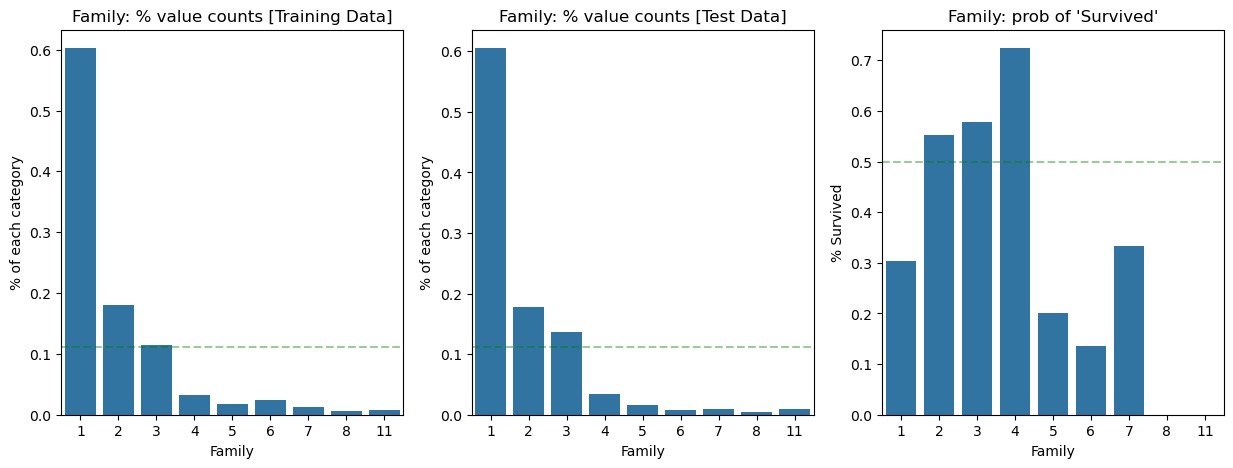

In [5]:
eda_bar_plots(feature='Family')

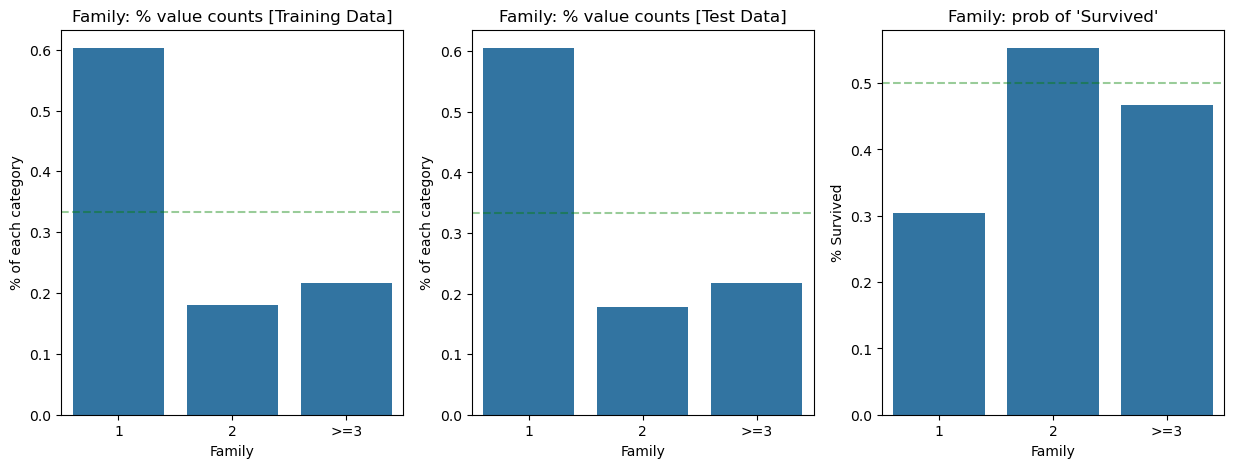

In [8]:
df_train['Family'] = df_train['Family'].map(
    lambda f : str(f) if f < 3 else '>=3'
)

df_test['Family'] = df_test['Family'].map(
    lambda f : str(f) if f < 3 else '>=3'
)

eda_bar_plots(feature='Family')

In [ ]:
# 'Cabin' 컬럼 드랍 (결측치가 너무 많음)
df_train = df_train.drop(columns=['Cabin'])
df_test = df_test.drop(columns=['Cabin'])

In [ ]:
# 'Ticket' 컬럼 드랍 (의미를 찾을수 없음)
df_train = df_train.drop(columns=['Ticket'])
df_test = df_test.drop(columns=['Ticket'])

In [ ]:
class AgeImputer(
    SimpleImputer, TransformerMixin
):
    """
    Age Imputer from 'honorific_title' column.

    There are four honorific titles: Mr, Mrs, Miss, Master.
    We proved that these groups have statistically different
    mean Ages (Independent T-tests).

    Imputation strategy:
        - fit:  compute the mean Age for each honorifit title
            Compute the mean Age for those who do not have title
        - transform:  if Age is missing for a passenger, if it has
            honorific title, the mean Age for that honorific title
            will be assigned. Else, the mean age for those who do
            not have title will be assigned.
    """

    def __init__(self) -> None:
        """
        Initialize an AgeImputer instance
        """

        # Initialize the parent Sklearn classes
        super().__init__()
        # Define the mappig {title_: mean Age for title_}
        self.title2age = {}
        # Define the mean age of those people with no title
        self.no_title_mean_age = None
        self.is_fitted = False


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fits the 'title2age' and 'honorific_title' using 'X'.

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        df_groupby = df_train.groupby(
            by='honorific_title'
        ).agg({'Age': 'mean'})
        self.title2age = df_groupby.to_dict()['Age']

        if X['honorific_title'].isna().sum() == 0:
            self.no_title_mean_age = X['Age'].mean()
        else:
            self.no_title_mean_age = X.loc[
                X['honorific_title'].isna(), 'Age'
            ].mean()
        self.is_fitted = True
        return self


    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Transform 'X' by imputing the missing values of 'Age'

        'X' is assumed to be Training Data (not Test Data!)
        'X' is assumed to be a non-empty data frame with
            (at least) the columns 'Age' and 'honorific_title'
        """

        if not self.is_fitted:
            raise Exception("Call the 'fit' method first")

        X_out = X.copy(deep=True)
        missing_age_idx = X.loc[X['Age'].isna(), :].index
        age_col_idx = np.where(X.columns == 'Age')[0][0]

        for idx in missing_age_idx:

            # get the honorific_title of the 'idx' row
            title = X.loc[idx,'honorific_title']

            if title in self.title2age:
                X_out.loc[idx, 'Age'] = self.title2age[title]
            else:
                X_out.loc[idx, 'Age'] = self.no_title_mean_age

        return X_out['Age'].to_frame()

In [ ]:
# Create three imputers, one for each feature having missing values
# 결측치 채우는 함수를 imputer라고 합니다.
age_imputer = AgeImputer().set_output(transform='pandas')

fare_imputer = SimpleImputer(
    strategy='median'
).set_output(transform='pandas')

embarked_imputer = SimpleImputer(
    strategy='most_frequent'
).set_output(transform='pandas')


# Create a general imputer (for all the variables)
imputer = ColumnTransformer(
    transformers=[
        ('age_imp', age_imputer, ['Age', 'honorific_title']),
        ('fare_imp', fare_imputer, ['Fare']),
        ('embarked_imp', embarked_imputer, ['Embarked'])
    ],
    remainder='passthrough', # 나머지는 놔둔다.
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
# 'honorific_title'은 두가지 용도로 사용 가능합니다. :
#   - (1) 'Age'의 결측값 채우기
#   - (2) 분류형 피쳐로 사용
#
# (1)번에만 쓸 거면, 'honorific_title'을 바로 쓰면 됩니다.
# 하지만 (2)번에도 쓸 거라면, [Mr, Mrs, Miss, Master] 각 호칭에 대한
# 새로운 이진(Y/N) 컬럼을 만들어줘야 합니다.
# 우리는 (2)번을 쓰는 시나리오를 채택하겠습니다.

# Create a copy of the original column to keep it in the data
df_train['dummy_honorific_title'] = df_train['honorific_title']
df_train = pd.get_dummies(
    data=df_train,
    columns=['dummy_honorific_title'],
    prefix='',
    prefix_sep='',
    dummy_na=False,  # Null 컬럼은 복사하지 않는다.
    drop_first=False,  # Top4 honorific titles 행은 전부 복사
    dtype=int
)

df_test['dummy_honorific_title'] = df_test['honorific_title']
df_test = pd.get_dummies(
    data=df_test,
    columns=['dummy_honorific_title'],
    prefix='',
    prefix_sep='',
    dummy_na=False,  # Null 컬럼은 복사하지 않는다.
    drop_first=False,  # Top4 honorific titles 행은 전부 복사
    dtype=int
)